### Data preparing

In [1]:
df = pd.read_csv('data/Ocean Discord Data Challenge Dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Date_day'] = df['Date'].astype(str).str[:10]
df['Date_month'] = df['Date'].astype(str).str[:7]
df['Date_quarter'] = df['Date'].astype(str).str[:4] + 'Q' + df['Date'].dt.quarter.astype(str)

df['id1'] = range(len(df))
df.sort_values('Date', inplace = True)

# channels
df['Channel0'] = df['Channel'].map(lambda x: x.split(' - ')[0].strip())
df['Channel1'] = df['Channel'].map(lambda x: x.split(' - ')[1].strip())
df['Channel2'] = df['Channel'].map(lambda x: x.split(' - ')[2].split('[')[0].strip()).map(lambda x: x.replace('︱','|').replace('┃','|'))
df['Channel2_img'] = df['Channel2'].map(lambda x: x.split('|')[0].strip())
df['Channel2'] = df['Channel2'].map(lambda x: x.split('|')[1].strip())
del df['Channel0']
del df['Channel']

# flag of bots
list_bots = [
    'MEE6#4876', 
    'GitHub', 
    'OceanDiffusion#4502', 
    'awesomeQA#0813', 
    'OceanGPT#0740', 
    'Ocean Protocol • TweetShift',
    'Coordinape Hook',
    'Caesar The Coordinape Bot',
    'Deleted User',
    'Midjourney Bot#9282',
    
]

df['flg_bot'] = 0
df.loc[df['Author'].isin(list_bots), 'flg_bot'] = 1

# get only words from message
df['Content2'] = df['Content'].fillna('').map(lambda x: re.sub(r'[^\w\s]','',x.lower()).strip())

# get stats
df['cnt_messages'] = 1
df['cnt_reactions']   = df['Reactions'].fillna('(0)').map(lambda x: sum([int(x1.split(')')[0].strip()) for x1 in x.split('(')[1:]]))
df['cnt_attachments'] = df['Attachments'].notnull().astype(int)
df['cnt_words'] = df['Content2'].map(lambda x: len(re.findall('\w+', x)))
df['cnt_chars'] = df['Content'].fillna('').map(lambda x: len(x))

# flags
df['flg_join'] = 0
df.loc[df['Content'] == 'Joined the server.', 'flg_join'] = 1
df.loc[df['flg_join'] == 1, 'cnt_messages'] = 0

df.to_pickle('data/df.pkl')
print(df.shape)
df[:5]

(84754, 21)


,AuthorID,Author,Date,Content,Attachments,Reactions,Date_day,Date_month,Date_quarter,id1,Channel1,Channel2,Channel2_img,flg_bot,Content2,cnt_messages,cnt_reactions,cnt_attachments,cnt_words,cnt_chars,flg_join
30165,451343325018980353,sheridan_oceanprotocol,2019-08-20 19:55:00,Joined the server.,NaN,NaN,2019-08-20,2019-08,2019Q3,30165,GENERAL,general-chat,💭,0,joined the server,0,0,0,3,18,1
30166,236850565382930432,kremalicious,2019-08-20 22:22:00,Joined the server.,NaN,NaN,2019-08-20,2019-08,2019Q3,30166,GENERAL,general-chat,💭,0,joined the server,0,0,0,3,18,1
30167,419839406636269569,brucepon.,2019-08-20 23:42:00,Joined the server.,NaN,NaN,2019-08-20,2019-08,2019Q3,30167,GENERAL,general-chat,💭,0,joined the server,0,0,0,3,18,1
30168,440793147564359681,sherwood#5539,2019-08-21 04:51:00,Joined the server.,NaN,NaN,2019-08-21,2019-08,2019Q3,30168,GENERAL,general-chat,💭,0,joined the server,0,0,0,3,18,1
30169,605328247097524237,Emilyyyy#7263,2019-08-21 23:21:00,Joined the server.,NaN,NaN,2019-08-21,2019-08,2019Q3,30169,GENERAL,general-chat,💭,0,joined the server,0,0,0,3,18,1


### Unflat reactions

In [2]:
# prepare data
out1 = list()
out2 = list()
for i,r in df[~df['Reactions'].isnull()].iterrows():
    out0 = r.Reactions.split(',')
    out1 += out0
    out2 += [r.id1]*len(out0)

df1 = pd.DataFrame({
    'id1': out2,
    'data': out1,
})
df1['reaction'] = df1['data'].map(lambda x: x.split('(')[0].strip())
df1['cnt'] = df1['data'].map(lambda x: x.split('(')[1].split(')')[0]).astype(int)
print(df1.shape)

df_react = df1
df_react.to_pickle('data/df_react.pkl')
df1[:5]

(8098, 4)


,id1,data,reaction,cnt
0,30369,👍🏻 (1),👍🏻,1
1,30463,🙌 (1),🙌,1
2,30463,😋 (1),😋,1
3,30501,Thumbsup (1),Thumbsup,1
4,30562,👌 (2),👌,2


In [3]:
df2 = df1.groupby('reaction')['cnt'].sum().sort_values(ascending = False)
print(df2.shape)
df2[:20]

(455,)


reaction
👍             3107
💯             2227
🔥             1677
❤️            1346
✅              842
ocean          694
🚀              682
👎              526
🤝              440
🌊              311
🙌              285
🙏              249
👋              244
👀              212
👏              183
OPAPShield     180
😂              156
🫂              151
👍🏻             149
💪              146
Name: cnt, dtype: int32

### Users stat tables

In [4]:
# users stat
df_users = df.groupby('Author').size().reset_index()
del df_users[0]

# dates
df_users1 = df[df['flg_join'] == 1].groupby('Author').Date.min().reset_index().rename(columns = {'Date': 'Date_joined'})
df_users2 = df[df['flg_join'] != 1].groupby('Author').Date.min().reset_index().rename(columns = {'Date': 'Date_first'})
df_users = df_users.merge(df_users1, how = 'left').merge(df_users2, how = 'left')
df_users['Date_joined'] = df_users['Date_joined'].fillna(df_users['Date_first'])
df_users['Date_diff'] = (df_users['Date_first'] - df_users['Date_joined']).dt.total_seconds()/60

# stat
feats_stat = 'cnt_messages	cnt_reactions	cnt_attachments	cnt_words	cnt_chars'.split('\t')
df_users1 = df[df['flg_join'] != 1].groupby('Author')[feats_stat].sum().reset_index()
df_users = df_users.merge(df_users1, how = 'left')

# stat2
feats_stat = 'Date_day	Channel2'.split('\t')
df_users1 = df.groupby('Author')[feats_stat].nunique().reset_index()
df_users = df_users.merge(df_users1, how = 'left')
df_users['flg_bot'] = df_users['Author'].map(lambda x: 1 if x in list_bots else 0)

df_users.to_pickle('data/df_users.pkl')
print(df_users.shape)
df_users.sort_values('cnt_messages', ascending = False)[:10]

(9025, 12)


,Author,Date_joined,Date_first,Date_diff,cnt_messages,cnt_reactions,cnt_attachments,cnt_words,cnt_chars,Date_day,Channel2,flg_bot
1554,MEE6#4876,2020-06-27 21:00:00,2020-06-27 22:12:00,72.00,"20,985.00",160.00,23.00,"1,045,895.00","9,780,663.00",1162,8,1
1130,GitHub,2020-11-25 22:44:00,2020-11-25 22:44:00,0.00,"15,696.00",3.00,0.00,0.00,0.00,897,1,1
3426,blockchainlugano,2020-12-21 03:58:00,2020-12-21 03:58:00,0.00,"1,207.00","2,810.00",26.00,"36,547.00","219,677.00",388,11,0
5847,kreigdk,2023-06-28 22:51:00,2023-06-28 22:51:00,0.00,"1,126.00",619.00,42.00,"24,248.00","162,308.00",187,15,0
4276,dotunwilfred.eth,2020-07-26 00:00:00,2020-07-26 00:00:00,0.00,"1,113.00",237.00,370.00,"35,177.00","271,745.00",396,4,0
3344,bhavingala,2021-05-01 13:12:00,2021-05-01 15:11:00,119.00,"1,014.00",126.00,55.00,"10,631.00","93,225.00",397,8,0
8833,zippy1979,2021-10-22 18:42:00,2021-10-22 18:45:00,3.00,903.00,910.00,41.00,"10,788.00","65,296.00",228,13,0
7364,robinlehmann,2020-05-26 00:01:00,2020-06-19 21:27:00,"35,846.00",855.00,385.00,13.00,"21,963.00","135,111.00",354,14,0
6072,lukas85#6738,2023-03-07 03:31:00,2023-03-07 03:31:00,0.00,802.00,64.00,11.00,"7,627.00","47,049.00",49,8,0
4272,doteth,2021-10-22 17:33:00,2021-10-22 17:33:00,0.00,676.00,"1,545.00",25.00,"17,623.00","117,625.00",258,17,0


In [5]:
# users for clustering

df['Date_weekday'] = df['Date'].dt.weekday
df['Date_hour'] = df['Date'].dt.hour // 4

df1 = df.groupby(['Author','Date_weekday'])['cnt_messages'].sum().unstack().fillna(0)
df1 = df1.apply(lambda x: x/sum(x), axis = 1)
df1.columns = [f'w_{i}' for i in range(1,8)]

df2 = df.groupby(['Author','Date_hour'])['cnt_words'].sum().unstack().fillna(0)
df2 = df2.apply(lambda x: x/sum(x), axis = 1)
df2.columns = ['h0_4','h5_8','h9_12','h12_16','h17_20','h21_24']

df_users2 = df1.reset_index().merge(df2.reset_index())
df_users2.to_pickle('data/df_users2.pkl')
print(df_users2.shape)
df_users2[:10]

(9025, 14)


,Author,w_1,w_2,w_3,w_4,w_5,w_6,w_7,h0_4,h5_8,h9_12,h12_16,h17_20,h21_24
0,! GD┘áShaibi#3385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.00,0.00,0.00,0.00,0.00
1,! Reko .#6689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,1.00,0.00
2,! SΓêåM#2947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.00,0.00,0.00,0.00,0.00
3,! ajjaxx.xp#8310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,1.00
4,! Arii#5937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,1.00
5,! Moath#6029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,1.00
6,! tufinhax#0184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,1.00,0.00
7,! 0000#0530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,1.00,0.00
8,! 1337#5778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.00,0.00,0.00,0.00,0.00
9,! Alix#5968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,1.00,0.00


### Get Ocean price from Binance

In [6]:
def get_binance(symbol = 'ETHUSDT', interval = '5m', num = 20000, limit = None, end = None):
    if end is not None:
        limit = 1000
        url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}&endTime={end}'
        df = pd.read_json(url)
        cols = ['Opentime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Closetime', 
                'Volume_quote', 'Trades_num','Taker_buy_base', 'Taker_buy_quote', 'Ignore']
        df.columns = cols
        df.drop_duplicates(inplace = True)
        df.sort_values('Opentime', inplace = True)
        df.reset_index(drop=True, inplace=True)

        # convert to UTC+0 
        TIMEZONE = 3
        df.index = [dt.fromtimestamp(x/1000) - relativedelta(hours=TIMEZONE) for x in df.Opentime]
        del df['Opentime']
        del df['Closetime']
        del df['Ignore']
        return df
    
    limit = 1000
    url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}'
    df = pd.read_json(url)
    end = df[0][0]
    
    for it in tqdm(range(num//limit-1)):
        url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}&endTime={end}'
        df1 = pd.read_json(url)
        df = pd.concat([df, df1])
        end = df1[0][0]
    
    cols = ['Opentime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Closetime', 
            'Volume_quote', 'Trades_num','Taker_buy_base', 'Taker_buy_quote', 'Ignore']
    df.columns = cols
    df.drop_duplicates(inplace = True)
    df.sort_values('Opentime', inplace = True)
    df.reset_index(drop=True, inplace=True)
    
    # convert to UTC+0 
    TIMEZONE = 3
    df.index = [dt.fromtimestamp(x/1000) - relativedelta(hours=TIMEZONE) for x in df.Opentime]
    del df['Opentime']
    del df['Closetime']
    del df['Ignore']
    return df

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.53it/s]


(1301, 9)


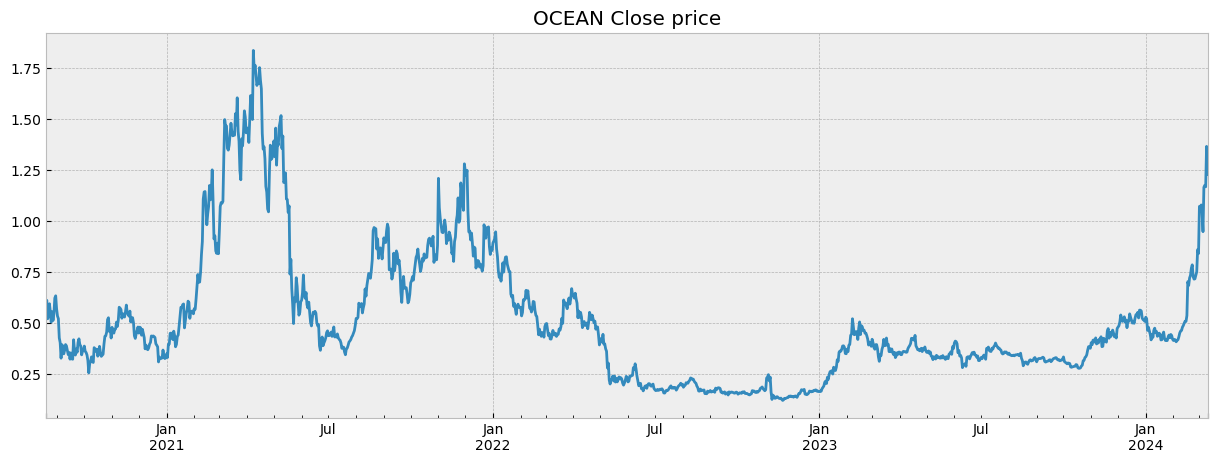

In [7]:
df = get_binance(
    symbol='OCEANUSDT',
    interval='1d',
    num=3000,
    limit=None,
    end=None,
)
df.to_pickle('data/df_price.pkl')
print(df.shape)
_ = df.Close.plot(figsize = (15,5), title = 'OCEAN Close price')